# Bidding engine development

# Contents

- [Imports](#imports)
    - [Libraries](#libraries)
    - [Raw data](#raw-data)
- [Processing](#processing)
    - [Missing values](#missing-values)
        - [Filling with forward fill](#filling-with-forward-fill)
        - [Filling with most frequent](#filling-with-most-frequent)
        - [Filling with nearest neighbors](#filling-with-neighbours)
    - [Converting object features to numerical](#converting-object-features-to-numerical)
    - [Scaling metrics features](#scaling-metrics-features)
    - [Downcasting numerical features](#downcasting-numerical-features)
    - [Dummy variable for broad match modifier](#dummy-variable-for-broad-match-modifier)
    - [Profiling interim data](#timeseries-of-the-random-feature-for-the-random-keyword)
    - [Convert CPC to GBP](#convert-cpc-to-gbp)
- [Quick look into keywords](#quick-look-into-keywords)
    - [Most sessions](#most-sessions)
    - [Least sessions](#least-sessions)
    - [Most impressions](#most-impressions)
    - [Least impressions](#least-impressions)
- [Processed data](#processed-data)
- [Keyword clustering](#keyword-clustering)
    - [Embedding](#embedding)
    - [k-means clustering](#k-means-clustering)
    - [Agglomerative clustering](#agglomerative-clustering)
- [Topic extraction](#topic-extraction)
- [Work in progress](#work-in-progress)

# Imports

## Libraries


In [133]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv

SEED = 10
np.random.seed(seed=SEED)
load_dotenv()

True

## Raw data

In [134]:
raw_df = pd.read_feather(
    os.path.join(os.environ['RAW_DATA_PATH'], 'bidding_data.feather'))
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587593 entries, 0 to 587592
Data columns (total 19 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   AdGroupId                         587593 non-null  int64         
 1   CampaignId                        587593 non-null  int64         
 2   CriterionId                       587593 non-null  int64         
 3   Date                              587593 non-null  datetime64[ns]
 4   CampaignName                      587593 non-null  object        
 5   AdGroupName                       587593 non-null  object        
 6   Criteria                          587593 non-null  object        
 7   CpcBid                            587593 non-null  float64       
 8   AbsoluteTopImpressionPercentage   587593 non-null  object        
 9   TopImpressionPercentage           587593 non-null  object        
 10  SearchImpressionShare           

In [135]:
raw_df.isna().sum()

AdGroupId                            0
CampaignId                           0
CriterionId                          0
Date                                 0
CampaignName                         0
AdGroupName                          0
Criteria                             0
CpcBid                               0
AbsoluteTopImpressionPercentage      0
TopImpressionPercentage              0
SearchImpressionShare                0
SearchTopImpressionShare             0
SearchRankLostTopImpressionShare     0
Impressions                          0
Clicks                               0
Cost                                39
Sessions                             0
Cost_gbp                             0
Margin                               0
dtype: int64

In [136]:
sum(raw_df.duplicated())

0

In [137]:
raw_df.head()

,AdGroupId,CampaignId,CriterionId,Date,CampaignName,AdGroupName,Criteria,CpcBid,AbsoluteTopImpressionPercentage,TopImpressionPercentage,SearchImpressionShare,SearchTopImpressionShare,SearchRankLostTopImpressionShare,Impressions,Clicks,Cost,Sessions,Cost_gbp,Margin
0,146372240840,19026016545,1224358859735,2022-10-07,GEN_Date,GEN_2023_Easter_Exact,easter 2023 holidays,1824000.0,0.0,0.0,< 10%,0.12,1.08,0,0.0,0.0,0.0,0.00000,0.0
1,143665838613,19032609979,436468614376,2022-11-17,GEN_Type_Type,GEN_5 Star_Beach_BMM,+beach +holidays +5 +star,2160000.0,0.348,1.2,53.85%,0.648,0.552,9,0.0,0.0,0.0,0.00000,0.0
2,142284478245,19032615052,151556316,2022-09-21,GEN_Type_Date,GEN_Cheap_Christmas_Exact,cheap christmas vacations,708000.0,0.8999999999999999,1.2,100.00%,1.2,0.0,9,1.2,1008000.0,1.2,1.02816,0.0
3,142284480445,19032615052,11690633763,2022-10-20,GEN_Type_Date,GEN_Deals_January_Exact,jan holiday deals,2544000.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00000,0.0
4,146372241280,19026016545,1416199961232,2022-11-17,GEN_Date,GEN_2023_August_BMM,+august +vacations +2023,1260000.0,0.0,0.0,100.00%,0.12,1.08,3,0.0,0.0,0.0,0.00000,0.0


In [138]:
raw_df.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
AdGroupId,587593.000000,143500715006.159119,1983820727.708377,138374060766.000000,142284480365.000000,143665829653.000000,143869938197.000000,149054263572.000000
CampaignId,587593.000000,19031107461.691029,2774769.592367,19026016545.000000,19032609979.000000,19032609979.000000,19032615052.000000,19033111187.000000
CriterionId,587593.000000,555324148771.488647,554367670369.387695,10341671.000000,17859937342.000000,325586290788.000000,1162214065887.000000,1906811999272.000000
CpcBid,587593.000000,1496895.483779,783301.658399,84000.000000,972000.000000,1356000.000000,1800000.000000,12768000.000000
Impressions,587593.000000,24.378759,136.797044,0.000000,0.000000,3.000000,14.000000,12901.000000
Clicks,587593.000000,2.589411,16.070534,0.000000,0.000000,0.000000,1.200000,1322.400000
Cost,587554.000000,2624619.354136,18296423.902132,0.000000,0.000000,0.000000,1500000.000000,1754172000.000000
Sessions,587593.000000,2.589270,16.070042,0.000000,0.000000,0.000000,1.200000,1322.400000
Cost_gbp,587593.000000,2.676909,18.660942,0.000000,0.000000,0.000000,1.530000,1789.255439
Margin,587593.000000,1.936043,24.625932,-122.145806,0.000000,0.000000,0.000000,2349.599376


Observations

1. 39 (out of 587,593) NaNs in `Cost` column. Nans rows can be dropped due to insignificant amount. Alternatively, can interpolated (forward fill) or imputed.

2. The following columns could be converted to numerical (floats) judging by the `.head()` and columns names
```
8   AbsoluteTopImpressionPercentage   587593 non-null  object        
9   TopImpressionPercentage           587593 non-null  object        
10  SearchImpressionShare             587593 non-null  object        
11  SearchTopImpressionShare          587593 non-null  object        
12  SearchRankLostTopImpressionShare  587593 non-null  object        
```

# Processing
[top](#contents)

In [139]:
interim_df = raw_df.copy(deep=True)
interim_df_sorted = interim_df.sort_values(
    by=['CriterionId', 'Date']).reset_index(drop=True)


In [140]:
def plot_keyword(df, criterion, features):
    '''
    The plot_keyword function takes a dataframe, criterion ID, and list of features to plot.
    It then plots the specified features for the given criterion ID.
    
    Parameters
    ----------
        df
            Pass the dataframe to the function
        criterion
            Select the keyword to plot
        features
            Specify which columns to plot
    '''
    for feature in features:
        plt.plot(df.loc[df['CriterionId'] == criterion, 'Date'],
                 df.loc[df['CriterionId'] == criterion, feature],
                 label=feature)
    plt.title('Keyword ID {}\nUnique keywords {}'.format(
        criterion, raw_df.loc[raw_df['CriterionId'] == criterion,
                              'Criteria'].unique()))
    plt.xticks(rotation=45)
    if len(features) == 1:
        plt.ylabel(feature)
    else:
        plt.legend()
    plt.show()

In [141]:
def plot_filled(df, criterion, features):
    '''
    The plot_filled function takes a dataframe, criterion ID, and list of features as input.
    It then plots the filled values for each feature in the list against the date.
    If there is only one feature in the list, it labels that axis with that feature name.
    
    Parameters
    ----------
        df
            Pass the dataframe to the function
        criterion
            Filter the dataframe to only show the rows that have a criterionid equal to criterion
        features
            Specify which columns to plot
    '''
    from matplotlib.markers import MarkerStyle

    markers = list(MarkerStyle.markers.keys())[1:len(features) + 1]
    plt.figure()
    for feature, marker in zip(features, markers):
        if 'filled' in feature:
            plt.plot(df.loc[(df['CriterionId'] == criterion)
                            & (df['Cost'].isna()), 'Date'],
                     df.loc[(df['CriterionId'] == criterion) &
                            (df['Cost'].isna()), feature],
                     marker,
                     label=feature)
        else:
            plt.plot(df.loc[df['CriterionId'] == criterion, 'Date'],
                     df.loc[df['CriterionId'] == criterion, feature],
                     label=feature)
    plt.title('Keyword ID {}\nUnique keywords {}'.format(
        criterion,
        df.sort_values(
            by=['CriterionId', 'Date']).loc[df['CriterionId'] == criterion,
                                            'Criteria'].unique()))
    plt.xticks(rotation=45)
    if len(features) == 1:
        plt.ylabel(feature)
    else:
        plt.legend()
    plt.show()

## Missing values

In [142]:
missing_criterionids = raw_df.loc[raw_df['Cost'].isnull(),
                                  'CriterionId'].unique()
print(f'unique keywords with missing values: {len(missing_criterionids)}')

unique keywords with missing values: 39


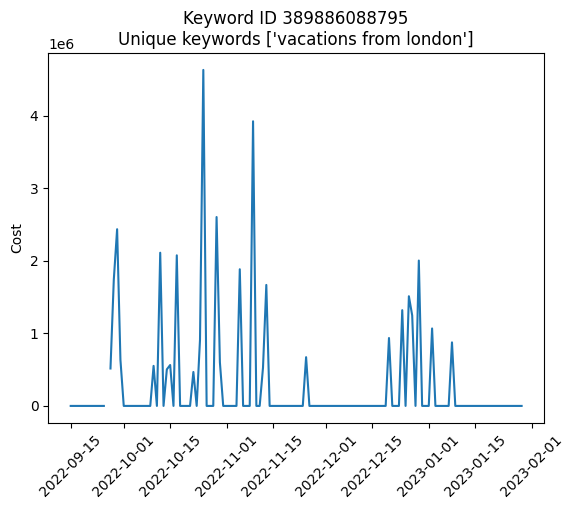

In [143]:
random_criterion_with_missing_cost = np.random.choice(missing_criterionids)
features = ['Cost']
plot_keyword(df=interim_df_sorted,
             criterion=random_criterion_with_missing_cost,
             features=features)


### Filling with forward fill

In [144]:
interim_df_sorted['Cost_forward_filled'] = interim_df_sorted[
    'Cost'].interpolate(method='ffill')


### Filling with most frequent

In [145]:
from sklearn.impute import SimpleImputer

frequency_imp = SimpleImputer(strategy='most_frequent')
interim_df_sorted['Cost_frequency_filled'] = interim_df_sorted['Cost'].copy(
    deep=True)
for criterion in missing_criterionids:
    interim_df_sorted.loc[
        interim_df_sorted['CriterionId'] == criterion,
        'Cost_frequency_filled'] = frequency_imp.fit_transform(
            interim_df_sorted.loc[
                interim_df_sorted['CriterionId'] == criterion,
                'Cost_frequency_filled'].values.reshape(-1, 1)).reshape(-1)

In [146]:
interim_df_sorted['Cost_mode_filled'] = interim_df_sorted['Cost'].copy(
    deep=True)
modes = []
for criterion in missing_criterionids:
    mode = interim_df_sorted.loc[interim_df_sorted['CriterionId'] == criterion,
                                 'Cost_mode_filled'].mode().values[0]
    interim_df_sorted.loc[interim_df_sorted['CriterionId'] == criterion,
                          'Cost_mode_filled'] = interim_df_sorted.loc[
                              interim_df_sorted['CriterionId'] == criterion,
                              'Cost_mode_filled'].fillna(value=mode)
    modes.append(mode)


### Filling with neighbours

In [147]:
from sklearn.impute import KNNImputer

knn_imp = KNNImputer(n_neighbors=5, weights='distance')
interim_df_sorted['Cost_knn_filled'] = interim_df_sorted['Cost'].copy(
    deep=True)
for criterion in missing_criterionids:
    interim_df_sorted.loc[
        interim_df_sorted['CriterionId'] == criterion,
        'Cost_knn_filled'] = knn_imp.fit_transform(interim_df_sorted.loc[
            interim_df_sorted['CriterionId'] == criterion,
            'Cost_knn_filled'].values.reshape(-1, 1)).reshape(-1)

Comparison of the filling methods on the random keyword

In [148]:
filled = interim_df_sorted.loc[interim_df_sorted['Cost'].isna(), [
    'Cost', 'Cost_knn_filled', 'Cost_forward_filled', 'Cost_frequency_filled',
    'Cost_mode_filled'
]]


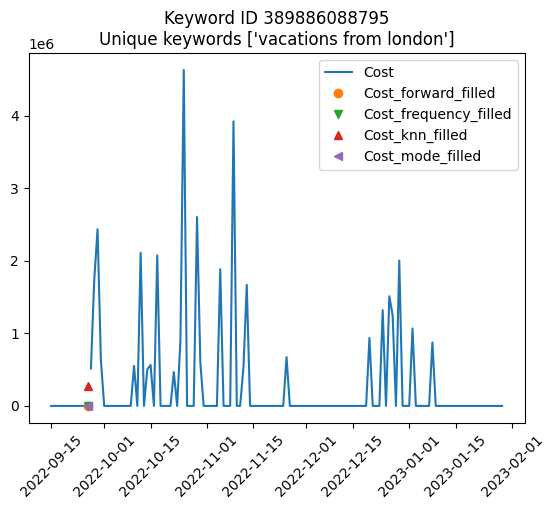

keyword 1592345682. mode: 0.0


In [149]:
plot_filled(
    df=interim_df_sorted,
    #   uncomment to see filling on a random keyword
    # criterion=np.random.choice(missing_criterionids),
    #   uncomment below to see filing on the same keyword as above
    criterion=random_criterion_with_missing_cost,
    features=[
        'Cost', 'Cost_forward_filled', 'Cost_frequency_filled',
        'Cost_knn_filled', 'Cost_mode_filled'
    ])
print('keyword {}. mode: {}'.format(
    criterion,
    interim_df_sorted.loc[interim_df_sorted['CriterionId'] == criterion,
                          'Cost'].mode()[0]))


Conclusion on filling NaNs

Due to sparsity of the data, filling with the most frequent (mode) per keyword value was chosen

In [150]:
interim_df_sorted_no_nans = interim_df_sorted.copy(deep=True)
interim_df_sorted_no_nans['Cost'] = interim_df_sorted_no_nans[
    'Cost_frequency_filled']
interim_df_sorted_no_nans.drop(
    columns=[
        # 'Cost_forward_filled',
        'Cost_frequency_filled',
        # 'Cost_knn_filled',
        # 'Cost_mode_filled',
    ],
    inplace=True)


## Converting object features to numerical

In [151]:
object_columns = [
    'AbsoluteTopImpressionPercentage', 'TopImpressionPercentage',
    'SearchImpressionShare', 'SearchTopImpressionShare',
    'SearchRankLostTopImpressionShare'
]

for col in object_columns:
    interim_df_sorted_no_nans[col] = interim_df_sorted_no_nans[col].str.lstrip(
        '<').str.rstrip('%').astype(float)

## Scaling metrics features

See the ranges of metrics in [Google Ad API](https://developers.google.com/google-ads/api/fields/v11/metrics)

In [152]:
for col in object_columns:
    interim_df_sorted_no_nans[col] = (interim_df_sorted_no_nans[col] -
                                      interim_df_sorted_no_nans[col].min()
                                      ) / interim_df_sorted_no_nans[col].max()
    if 'Percentage' in col:
        interim_df_sorted_no_nans[col] *= 100

## Downcasting numerical features

In [153]:
fcols = interim_df_sorted_no_nans.select_dtypes('float').columns
icols = interim_df_sorted_no_nans.select_dtypes('integer').columns

interim_df_sorted_no_nans[fcols] = interim_df_sorted_no_nans[fcols].apply(
    pd.to_numeric, downcast='float')
interim_df_sorted_no_nans[icols] = interim_df_sorted_no_nans[icols].apply(
    pd.to_numeric, downcast='integer')


## Dummy variable for broad match modifier

For the same index, AdGroupName can contain BMM in the name, but Criteria may not include it. '+' in Criteria is prevailing

In [154]:
interim_df_sorted_no_nans['BMM'] = interim_df_sorted_no_nans[
    'Criteria'].str.contains('+', regex=False).astype(np.int8)


In [155]:
interim_df_sorted_no_nans[
    interim_df_sorted_no_nans['AdGroupName'].str.contains('BMM')]


,AdGroupId,CampaignId,CriterionId,Date,CampaignName,AdGroupName,Criteria,CpcBid,AbsoluteTopImpressionPercentage,TopImpressionPercentage,...,Impressions,Clicks,Cost,Sessions,Cost_gbp,Margin,Cost_forward_filled,Cost_mode_filled,Cost_knn_filled,BMM
18906,146372248200,19026016545,169110804,2022-11-28,GEN_Date _Metis,GEN_Christmas Markets_BMM,christmas markets,1644000.0,0.0,0.0,...,0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0
18907,146372248200,19026016545,169110804,2022-11-29,GEN_Date _Metis,GEN_Christmas Markets_BMM,christmas markets,1644000.0,71.0,82.0,...,162,3.6,4452000.0,3.6,4.54104,0.0,4452000.0,4452000.0,4452000.0,0
18908,146372248200,19026016545,169110804,2022-11-30,GEN_Date _Metis,GEN_Christmas Markets_BMM,christmas markets,1644000.0,47.0,72.0,...,108,1.2,1272000.0,1.2,1.29744,0.0,1272000.0,1272000.0,1272000.0,0
18909,146372248200,19026016545,169110804,2022-12-01,GEN_Date _Metis,GEN_Christmas Markets_BMM,christmas markets,1644000.0,40.0,78.0,...,101,2.4,2412000.0,2.4,2.46024,0.0,2412000.0,2412000.0,2412000.0,0
18910,146372248200,19026016545,169110804,2022-12-02,GEN_Date _Metis,GEN_Christmas Markets_BMM,christmas markets,1500000.0,55.0,83.0,...,113,6.0,4788000.0,6.0,4.88376,0.0,4788000.0,4788000.0,4788000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586788,140745324621,19032615052,1906811994152,2023-01-25,GEN_Type_Date _Metis,GEN_Sun_2024_BMM,sun holidays 2024,2772000.0,0.0,100.0,...,2,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0
586789,140745324621,19032615052,1906811994152,2023-01-26,GEN_Type_Date _Metis,GEN_Sun_2024_BMM,sun holidays 2024,2772000.0,67.0,100.0,...,5,1.2,3288000.0,1.2,3.35376,0.0,3288000.0,3288000.0,3288000.0,0
586790,140745324621,19032615052,1906811994152,2023-01-27,GEN_Type_Date _Metis,GEN_Sun_2024_BMM,sun holidays 2024,2772000.0,75.0,100.0,...,5,2.4,4560000.0,2.4,4.65120,0.0,4560000.0,4560000.0,4560000.0,0
586791,140745324621,19032615052,1906811994152,2023-01-28,GEN_Type_Date _Metis,GEN_Sun_2024_BMM,sun holidays 2024,2772000.0,100.0,100.0,...,8,1.2,1008000.0,1.2,1.02816,0.0,1008000.0,1008000.0,1008000.0,0


In [156]:
interim_df_sorted_no_nans[interim_df_sorted_no_nans['Criteria'].str.contains(
    '+', regex=False)]


,AdGroupId,CampaignId,CriterionId,Date,CampaignName,AdGroupName,Criteria,CpcBid,AbsoluteTopImpressionPercentage,TopImpressionPercentage,...,Impressions,Clicks,Cost,Sessions,Cost_gbp,Margin,Cost_forward_filled,Cost_mode_filled,Cost_knn_filled,BMM
146752,143665847893,19032609979,17854570816,2022-09-15,GEN_Type_Type,GEN_Break_Last Minute_BMM,+last +minute +short +breaks,1500000.0,50.0,88.0,...,13,1.2,768000.0,1.2,0.78336,0.000000,768000.0,768000.0,768000.0,1
146753,143665847893,19032609979,17854570816,2022-09-16,GEN_Type_Type,GEN_Break_Last Minute_BMM,+last +minute +short +breaks,1500000.0,50.0,100.0,...,4,0.0,0.0,0.0,0.00000,7.893422,0.0,0.0,0.0,1
146754,143665847893,19032609979,17854570816,2022-09-17,GEN_Type_Type,GEN_Break_Last Minute_BMM,+last +minute +short +breaks,1500000.0,0.0,33.0,...,8,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,1
146755,143665847893,19032609979,17854570816,2022-09-18,GEN_Type_Type,GEN_Break_Last Minute_BMM,+last +minute +short +breaks,1500000.0,0.0,100.0,...,5,1.2,816000.0,1.2,0.83232,0.000000,816000.0,816000.0,816000.0,1
146756,143665847893,19032609979,17854570816,2022-09-19,GEN_Type_Type,GEN_Break_Last Minute_BMM,+last +minute +short +breaks,1500000.0,0.0,0.0,...,0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542685,146372242240,19026016545,1416199964792,2023-01-25,GEN_Date _Metis,GEN_2023_Winter_BMM,+winter +vacations +2023,1956000.0,100.0,100.0,...,2,1.2,2184000.0,1.2,2.22768,0.000000,2184000.0,2184000.0,2184000.0,1
542686,146372242240,19026016545,1416199964792,2023-01-26,GEN_Date _Metis,GEN_2023_Winter_BMM,+winter +vacations +2023,1956000.0,0.0,100.0,...,1,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,1
542687,146372242240,19026016545,1416199964792,2023-01-27,GEN_Date _Metis,GEN_2023_Winter_BMM,+winter +vacations +2023,1956000.0,67.0,100.0,...,12,2.4,2244000.0,2.4,2.28888,0.000000,2244000.0,2244000.0,2244000.0,1
542688,146372242240,19026016545,1416199964792,2023-01-28,GEN_Date _Metis,GEN_2023_Winter_BMM,+winter +vacations +2023,1956000.0,20.0,100.0,...,9,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,1


<!-- ## Replacing non alphanum in keywords -->

In [157]:
all(interim_df_sorted_no_nans['Criteria'].str.islower())

True

In [159]:
interim_df_sorted_no_nans['Criteria'] = interim_df_sorted_no_nans[
    'Criteria'].str.replace(r'[^\w\s]+', '', regex=True)


## Profiling interim data

In [160]:
if 'interim_data.html' not in os.listdir(os.environ['DATA_PROFILES_PATH']):
    from ydata_profiling import ProfileReport

    os.makedirs(os.environ['DATA_PROFILES_PATH'], exist_ok=True)
    interim_data_profile = ProfileReport(interim_df_sorted_no_nans,
                                         title='Interim Data Profile')
    interim_data_profile.to_file(
        os.path.join(os.environ['DATA_PROFILES_PATH'], 'interim_data.html'))
    del interim_data_profile


<!-- ## Add ROI -->

In [161]:
# interim_df_sorted_no_nans['ROI_gbp'] = interim_df_sorted_no_nans[
#     'Margin'].divide(interim_df_sorted_no_nans['Cost_gbp'],
#                      fill_value=0).replace({
#                          np.inf: 0,
#                          np.nan: 0
#                      })
# interim_df_sorted_no_nans['ROI'] = interim_df_sorted_no_nans['Margin'].divide(
#     interim_df_sorted_no_nans['Cost'], fill_value=0).replace({
#         np.inf: 0,
#         np.nan: 0
#     })


## Convert CPC to GBP

In [162]:
micros_to_gbp = interim_df_sorted_no_nans['Cost'].div(
    interim_df_sorted_no_nans['Cost_gbp']).replace({
        np.nan: 0,
        np.inf: 0
    }).unique()[1:].mean()


In [163]:
interim_df_sorted_no_nans[
    'CpcBid_gbp'] = interim_df_sorted_no_nans['CpcBid'] / micros_to_gbp


# Quick look into keywords
[top](#contents)

## Unique keyword ids

In [164]:
len(interim_df_sorted_no_nans['CriterionId'].unique())

4320

## Unique keyword ids with positive sessions

In [165]:
len(interim_df_sorted_no_nans.loc[(interim_df_sorted_no_nans['Margin'] > 0) &
                                  (interim_df_sorted_no_nans['Sessions'] > 0),
                                  'CriterionId'].unique())


2503

## Negative margins

In [166]:
negative_margins = interim_df_sorted_no_nans.loc[
    interim_df_sorted_no_nans['Margin'] < 0, 'CriterionId'].unique()


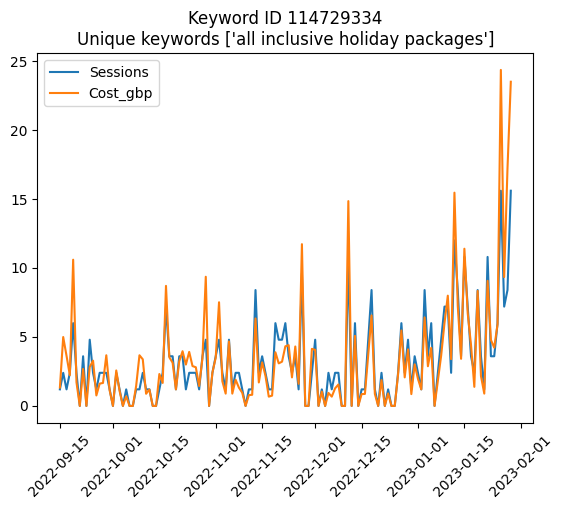

Negative margins: [-2.7061143] at 13137    2023-01-15
Name: Date, dtype: object


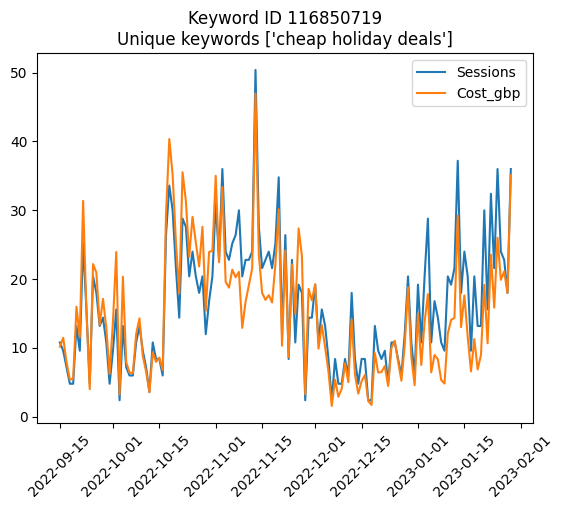

Negative margins: [-6.271931] at 13583    2022-10-05
Name: Date, dtype: object


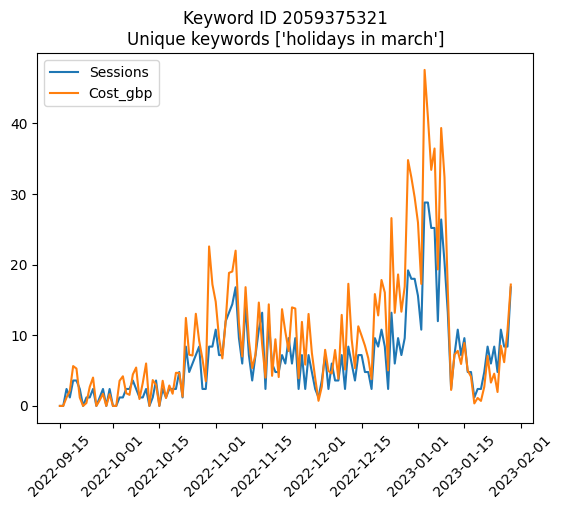

Negative margins: [-0.45185876] at 75498    2023-01-16
Name: Date, dtype: object


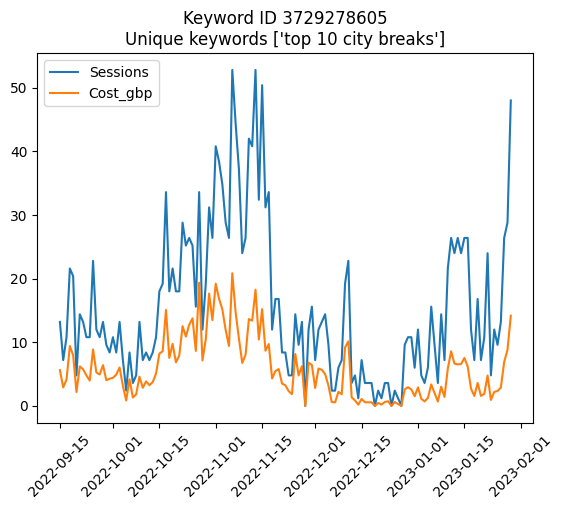

Negative margins: [-4.7134953] at 91468    2022-11-18
Name: Date, dtype: object


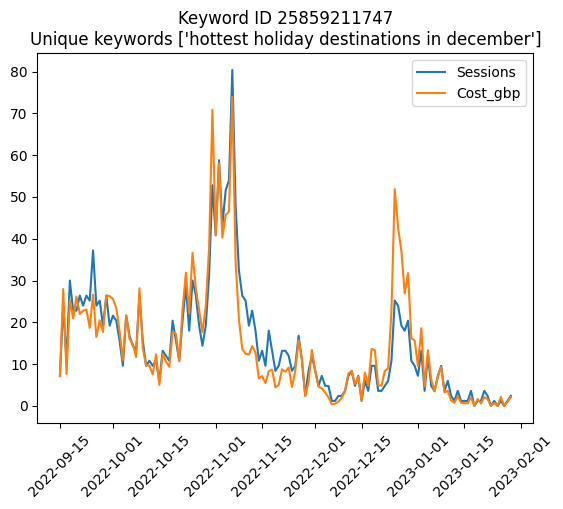

Negative margins: [-3.6482835] at 155021    2022-11-03
Name: Date, dtype: object


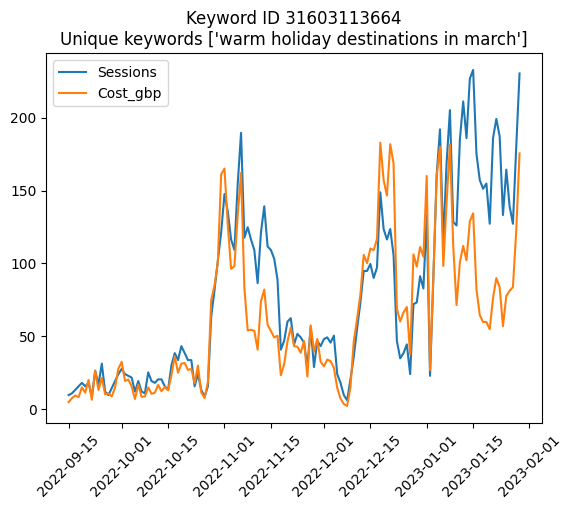

Negative margins: [-122.145805] at 160649    2023-01-27
Name: Date, dtype: object


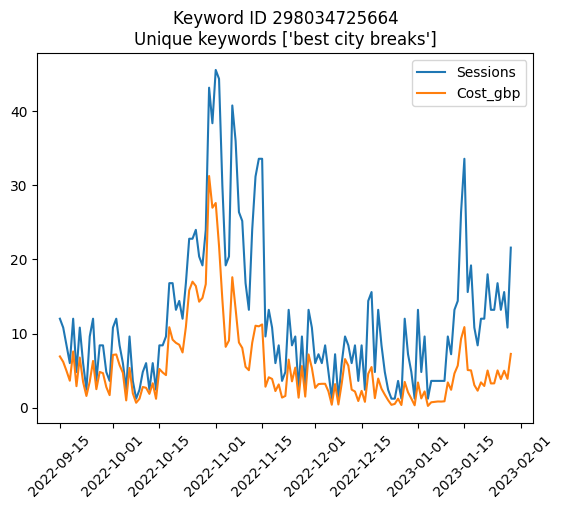

Negative margins: [-2.761438] at 196044    2023-01-24
Name: Date, dtype: object


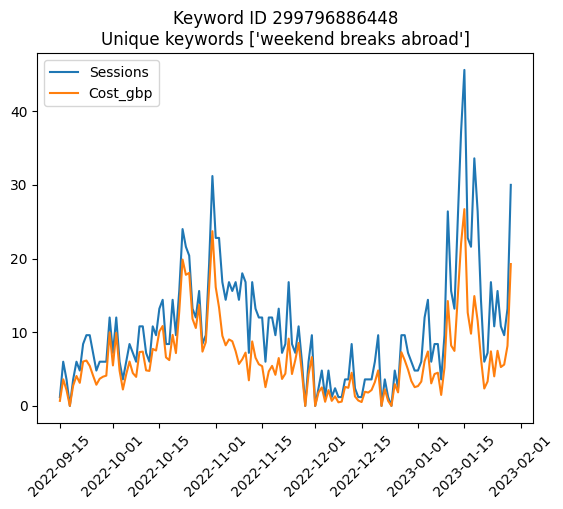

Negative margins: [-19.80198] at 203929    2022-11-24
Name: Date, dtype: object


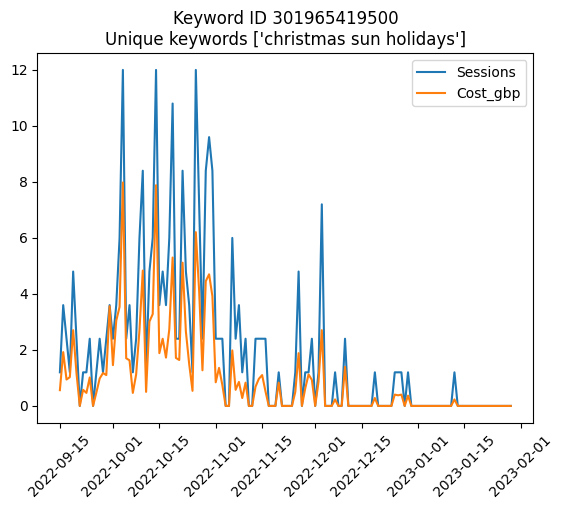

Negative margins: [-1.2024386] at 212946    2022-10-30
Name: Date, dtype: object


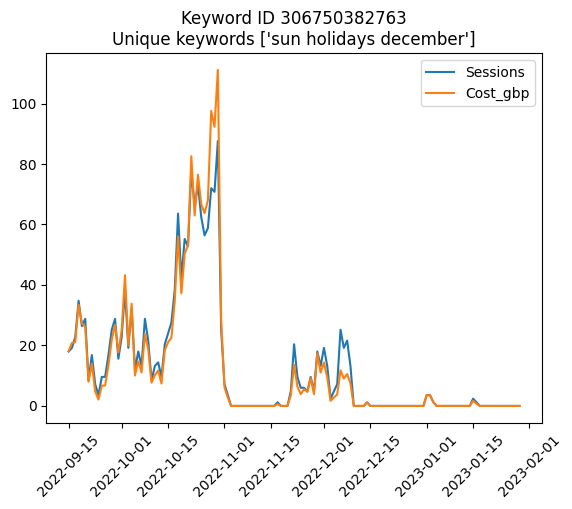

Negative margins: [-0.14227723] at 228796    2022-12-01
Name: Date, dtype: object


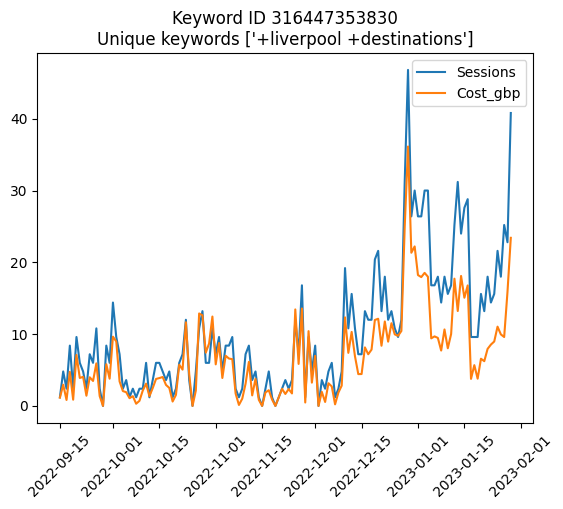

Negative margins: [-83.62362] at 255076    2022-09-16
Name: Date, dtype: object


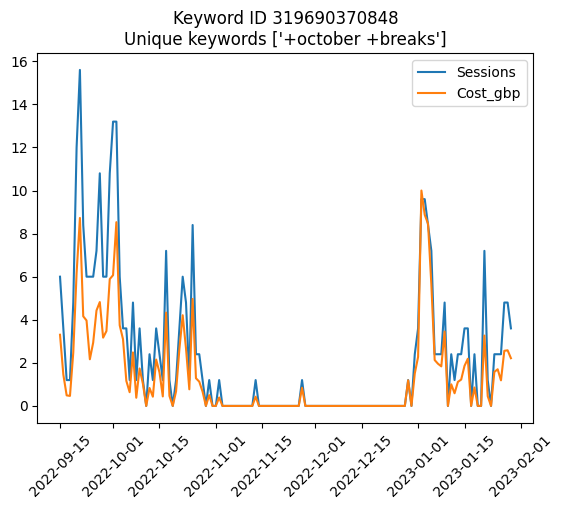

Negative margins: [-83.43191] at 278270    2022-09-16
Name: Date, dtype: object


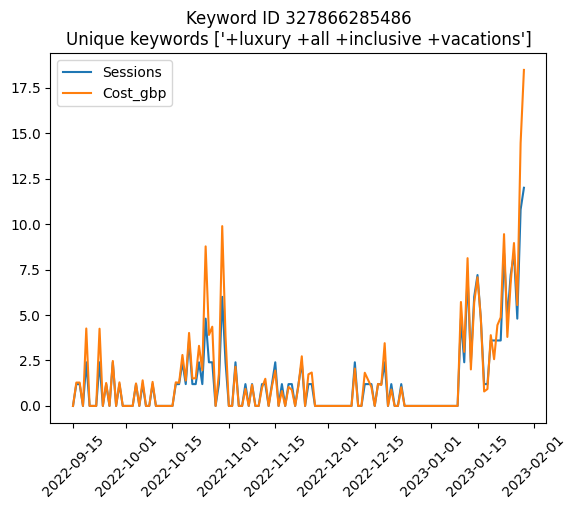

Negative margins: [-1.1051224] at 298042    2022-10-30
Name: Date, dtype: object


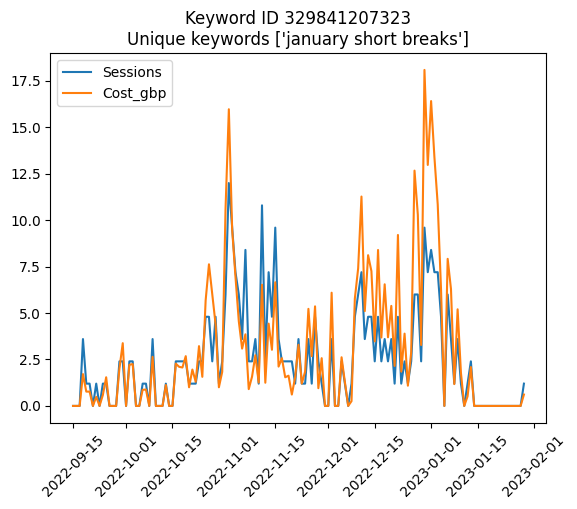

Negative margins: [-0.5656506] at 301358    2022-11-27
Name: Date, dtype: object


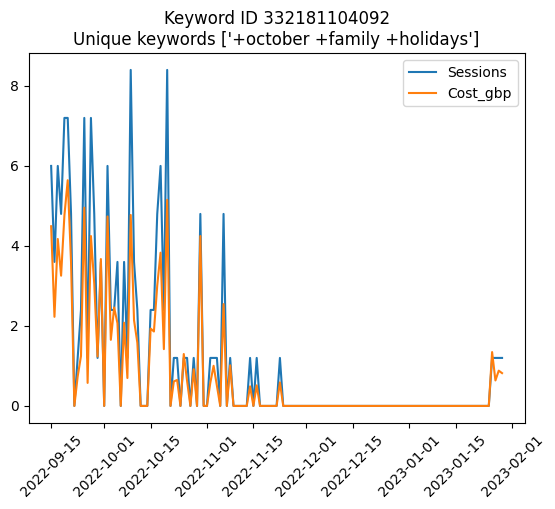

Negative margins: [-83.52625] at 307267    2022-09-16
Name: Date, dtype: object


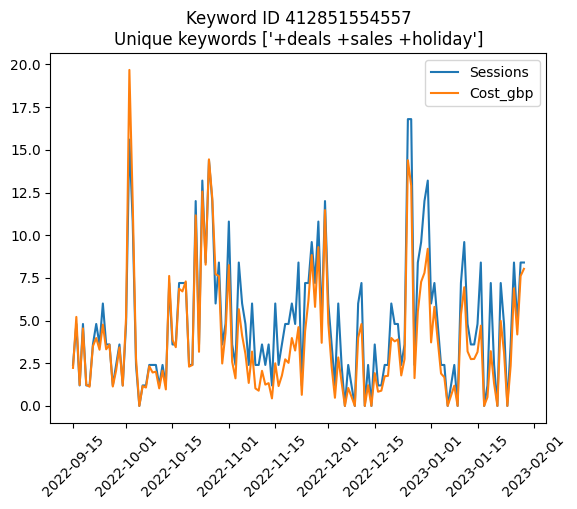

Negative margins: [-1.4543619] at 374282    2022-09-15
Name: Date, dtype: object


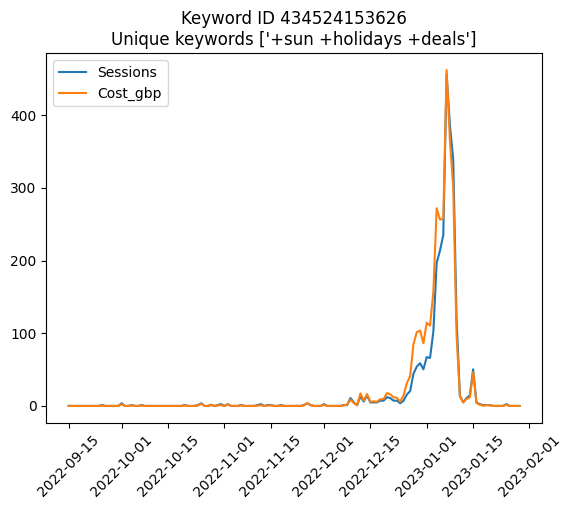

Negative margins: [-16.082891] at 376181    2023-01-11
Name: Date, dtype: object


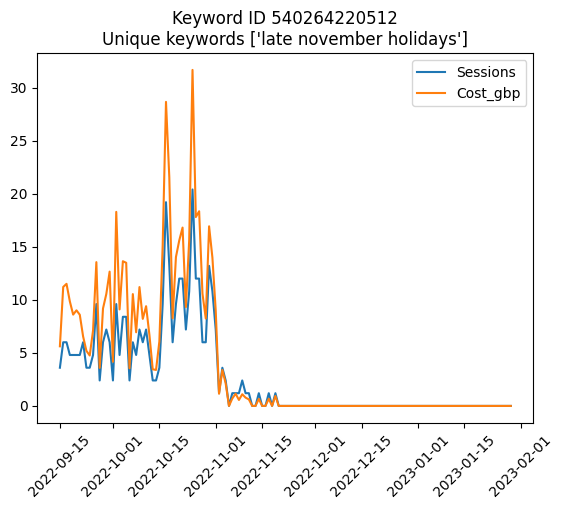

Negative margins: [-9.85948] at 383785    2022-11-04
Name: Date, dtype: object


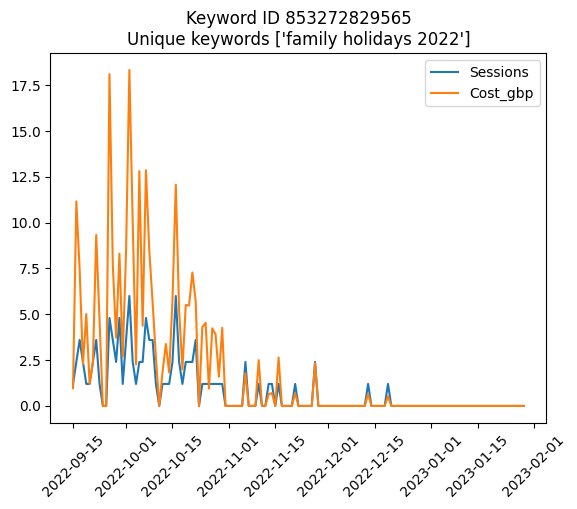

Negative margins: [-29.416378] at 397171    2022-10-17
Name: Date, dtype: object


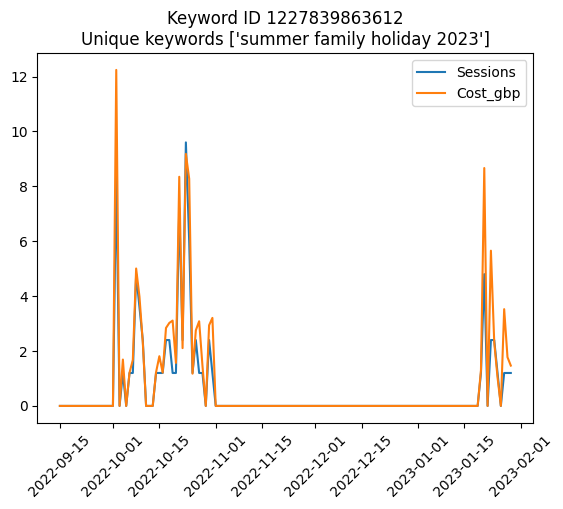

Negative margins: [-1.0710093] at 534863    2022-10-30
Name: Date, dtype: object


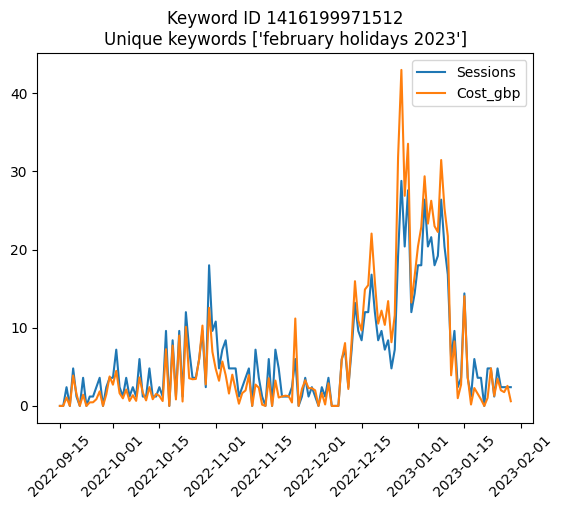

Negative margins: [-32.880077] at 546378    2023-01-19
Name: Date, dtype: object


In [167]:
for criterion in negative_margins:
    plot_keyword(df=interim_df_sorted_no_nans,
                 criterion=criterion,
                 features=['Sessions', 'Cost_gbp'])
    print('Negative margins: {} at {}'.format(interim_df_sorted_no_nans.loc[
        (interim_df_sorted_no_nans['CriterionId'] == criterion) &
        (interim_df_sorted_no_nans['Margin'] < 0), 'Margin'].values, interim_df_sorted_no_nans.loc[
        (interim_df_sorted_no_nans['CriterionId'] == criterion) &
        (interim_df_sorted_no_nans['Margin'] < 0), 'Date'].dt.date))


In this context, the negative margins are unlikely to mean loss. Apply abs() to margins

In [168]:
interim_df_sorted_no_nans['Margin'] = abs(interim_df_sorted_no_nans['Margin'])

## Most sessions

In [169]:
most_sessions = interim_df_sorted_no_nans.sort_values(
    by=['Sessions'],
    ascending=False).loc[interim_df_sorted_no_nans['Margin'] > 0,
                         'CriterionId'][:75].unique()
print(most_sessions)
interim_df_sorted_no_nans.loc[
    interim_df_sorted_no_nans['CriterionId'].isin(most_sessions),
    'Criteria'].unique()

[1161551891012 1210258704454      28171120  371829061397 1224358859975
 1058788934121]


array(['city breaks', 'half term holidays', 'all inclusive holidays 2023',
       'holidays 2023', 'cheap holidays 2023', 'easter holidays 2023'],
      dtype=object)

## Least sessions

In [170]:
least_sessions = interim_df_sorted_no_nans.sort_values(
    by=['Sessions'], ascending=True)['CriterionId'].unique()[:10]
print(least_sessions)
interim_df_sorted_no_nans.loc[
    interim_df_sorted_no_nans['CriterionId'].isin(least_sessions),
    'Criteria'].unique()

[    10341671 374901682957 374477784176 376861730083 373125841645
 373023664447 372921549487 383313093317 383321717437 383306041437]


array(['winter vacations', 'single group holidays',
       'cheap holidays summer', 'holiday deals late', 'feb vacations',
       'very cheap holidays abroad all inclusive',
       'lads package holidays', 'summer bargain holidays',
       'cheap discount holidays', 'cheap self catering holiday'],
      dtype=object)

## Most impressions

In [171]:
most_impressions = interim_df_sorted_no_nans.sort_values(
    by=['Impressions'], ascending=False)['CriterionId'].unique()[:10]
print(most_impressions)
interim_df_sorted_no_nans.loc[
    interim_df_sorted_no_nans['CriterionId'].isin(most_impressions),
    'Criteria'].unique()

[ 371829061397 1109001687720 1224358859975 1161551891012  305548399133
  303054917163      28171120     674372683  434524153626 1210258704454]


array(['city breaks', 'xmas markets', 'new years holidays',
       'new years vacations', 'half term holidays', 'sun holidays deals',
       'holidays new year 2022', 'holidays 2023', 'cheap holidays 2023',
       'easter holidays 2023'], dtype=object)

## Least impressions

In [172]:
least_impressions = interim_df_sorted_no_nans.sort_values(
    by=['Impressions'], ascending=True)['CriterionId'].unique()[:10]
print(least_impressions)
interim_df_sorted_no_nans.loc[
    interim_df_sorted_no_nans['CriterionId'].isin(least_impressions),
    'Criteria'].unique()

[325586290788 352388655012 352388653892 352395524543 350271886521
 351428853727 352078257487 352388653652 354676326914 354566414810]


array(['cheap holidays villa', 'holidays from inverness', 'bargain hotel',
       'hotel 5 star', 'break easter holiday', 'deals easter holiday',
       'break easter holidays', 'half term october holidays',
       '5 star all inclusive vacations',
       'villa holidays for large groups'], dtype=object)

# Processed data
[top](#contents)

In [173]:
processed_df = interim_df_sorted_no_nans.copy(deep=True)
fcols = processed_df.select_dtypes('float').drop(
    columns=['Cost', 'CpcBid']).columns.to_list()

In [174]:
processed_df = processed_df[
    ['CriterionId', 'Criteria', 'Date', 'Impressions', 'BMM'] + fcols]


In [175]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587593 entries, 0 to 587592
Data columns (total 18 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   CriterionId                       587593 non-null  int64         
 1   Criteria                          587593 non-null  object        
 2   Date                              587593 non-null  datetime64[ns]
 3   Impressions                       587593 non-null  int16         
 4   BMM                               587593 non-null  int8          
 5   AbsoluteTopImpressionPercentage   587593 non-null  float32       
 6   TopImpressionPercentage           587593 non-null  float32       
 7   SearchImpressionShare             587593 non-null  float32       
 8   SearchTopImpressionShare          587593 non-null  float32       
 9   SearchRankLostTopImpressionShare  587593 non-null  float32       
 10  Clicks                          

In [176]:
processed_df.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
CriterionId,587593.000000,555324148771.488647,554367670369.387573,10341671.000000,17859937342.000000,325586290788.000000,1162214065887.000000,1906811999272.000000
Impressions,587593.000000,24.378759,136.797044,0.000000,0.000000,3.000000,14.000000,12901.000000
BMM,587593.000000,0.304107,0.460028,0.000000,0.000000,0.000000,1.000000,1.000000
AbsoluteTopImpressionPercentage,587593.000000,25.111069,33.268330,0.000000,0.000000,0.000000,50.000000,100.000000
TopImpressionPercentage,587593.000000,55.290203,46.523636,0.000000,0.000000,83.000000,100.000000,100.000000
SearchImpressionShare,587593.000000,0.440689,0.403314,0.000000,0.000000,0.421100,0.857100,1.000000
SearchTopImpressionShare,587593.000000,0.407759,0.389220,0.000000,0.000000,0.330000,0.780000,1.000000
SearchRankLostTopImpressionShare,587593.000000,0.292140,0.357918,0.000000,0.000000,0.088889,0.555556,1.000000
Clicks,587593.000000,2.589411,16.070534,0.000000,0.000000,0.000000,1.200000,1322.400024
Sessions,587593.000000,2.589270,16.070042,0.000000,0.000000,0.000000,1.200000,1322.400024


In [177]:
processed_df.head()

,CriterionId,Criteria,Date,Impressions,BMM,AbsoluteTopImpressionPercentage,TopImpressionPercentage,SearchImpressionShare,SearchTopImpressionShare,SearchRankLostTopImpressionShare,Clicks,Sessions,Cost_gbp,Margin,Cost_forward_filled,Cost_mode_filled,Cost_knn_filled,CpcBid_gbp
0,10341671,winter vacations,2022-09-15,8,0,60.0,100.0,0.4167,0.42,0.644444,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,1.217939
1,10341671,winter vacations,2022-09-16,2,0,100.0,100.0,0.3333,0.33,0.744444,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,1.217939
2,10341671,winter vacations,2022-09-17,4,0,100.0,100.0,0.4000,0.40,0.666667,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,1.217939
3,10341671,winter vacations,2022-09-18,3,0,100.0,100.0,1.0000,1.00,0.000000,1.2,1.2,0.79560,0.0,780000.0,780000.0,780000.0,1.217939
4,10341671,winter vacations,2022-09-19,18,0,71.0,86.0,0.6364,0.55,0.500000,1.2,1.2,0.74664,0.0,732000.0,732000.0,732000.0,1.217939


## Profiling processed data

In [178]:
if 'processed_data.html' not in os.listdir(os.environ['DATA_PROFILES_PATH']):
    from ydata_profiling import ProfileReport

    os.makedirs(os.environ['DATA_PROFILES_PATH'], exist_ok=True)
    processed_data_profile = ProfileReport(processed_df,
                                           title='Processed Data Profile')
    processed_data_profile.to_file(
        os.path.join(os.environ['DATA_PROFILES_PATH'], 'processed_data.html'))
    del processed_data_profile

## Adding Criteria_bmm_ignored

In [179]:
processed_df['Criteria_bmm_ignored'] = processed_df['Criteria'].str.replace(
    r'[^\w\s]+', '', regex=True)


# Keyword clustering
[top](#contents)

## Embedding

In [180]:
del raw_df, interim_df_sorted_no_nans, interim_df_sorted

In [181]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v1')


In [182]:
kwds = processed_df['Criteria'].unique()
print(len(kwds))
kwds

3394


array(['winter vacations', 'cheap hotels', 'short beach breaks', ...,
       'christmas break 2024', 'package holidays 2024',
       'party holidays 2024'], dtype=object)

In [183]:
kwds_no_bmm = processed_df['Criteria'].str.replace(r'[^\w\s]+', '',
                                                   regex=True).unique()
print(len(kwds_no_bmm))
kwds_no_bmm

3394


array(['winter vacations', 'cheap hotels', 'short beach breaks', ...,
       'christmas break 2024', 'package holidays 2024',
       'party holidays 2024'], dtype=object)

In [184]:
kwds_embeddings = model.encode(kwds_no_bmm)
kwds_embeddings.shape

(3394, 384)

## k-means clustering

In [185]:
def get_clusters(clusters, return_clustered=False, print=False):
    clustered = {}
    for i, cluster_id in enumerate(clusters):
        if cluster_id not in clustered:
            clustered[cluster_id] = []
        clustered[cluster_id].append(kwds_no_bmm[i])
    if print:
        for i, kw in sorted(clustered.items()):
            print('Cluster {}, {} elements\n{}\n'.format(i + 1, len(kw), kw))

    if return_clustered:
        return clustered

In [186]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

n_clusters = 5
kmeans_model = KMeans(n_clusters=n_clusters,
                      max_iter=500,
                      n_init=100,
                      init='k-means++',
                      random_state=SEED)
kmeans_model.fit(normalize(kwds_embeddings))
kmeans_clusters = kmeans_model.labels_

In [187]:
get_clusters(kmeans_clusters)

## Agglomerative clustering

In [188]:
from sklearn.cluster import AgglomerativeClustering

agglomerative_model = AgglomerativeClustering(n_clusters=None,
                                              metric='cosine',
                                              linkage='complete',
                                              distance_threshold=0.9)
agglomerative_model.fit(kwds_embeddings)
agglo_clusters = agglomerative_model.labels_

In [189]:
clustered = get_clusters(agglo_clusters, return_clustered=True)

In [190]:
processed_df['Agglomerated_cluster'] = processed_df[
    'Criteria_bmm_ignored'].map(
        lambda x: [k for k, v in clustered.items() if x in v][0])
processed_df


,CriterionId,Criteria,Date,Impressions,BMM,AbsoluteTopImpressionPercentage,TopImpressionPercentage,SearchImpressionShare,SearchTopImpressionShare,SearchRankLostTopImpressionShare,Clicks,Sessions,Cost_gbp,Margin,Cost_forward_filled,Cost_mode_filled,Cost_knn_filled,CpcBid_gbp,Criteria_bmm_ignored,Agglomerated_cluster
0,10341671,winter vacations,2022-09-15,8,0,60.0,100.0,0.4167,0.42,0.644444,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,1.217939,winter vacations,16
1,10341671,winter vacations,2022-09-16,2,0,100.0,100.0,0.3333,0.33,0.744444,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,1.217939,winter vacations,16
2,10341671,winter vacations,2022-09-17,4,0,100.0,100.0,0.4000,0.40,0.666667,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,1.217939,winter vacations,16
3,10341671,winter vacations,2022-09-18,3,0,100.0,100.0,1.0000,1.00,0.000000,1.2,1.2,0.79560,0.0,780000.0,780000.0,780000.0,1.217939,winter vacations,16
4,10341671,winter vacations,2022-09-19,18,0,71.0,86.0,0.6364,0.55,0.500000,1.2,1.2,0.74664,0.0,732000.0,732000.0,732000.0,1.217939,winter vacations,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587588,1906811999272,party holidays 2024,2023-01-25,1,0,0.0,100.0,1.0000,1.00,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.816019,party holidays 2024,6
587589,1906811999272,party holidays 2024,2023-01-26,0,0,0.0,0.0,0.0000,0.00,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.816019,party holidays 2024,6
587590,1906811999272,party holidays 2024,2023-01-27,2,0,100.0,100.0,1.0000,1.00,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.816019,party holidays 2024,6
587591,1906811999272,party holidays 2024,2023-01-28,1,0,0.0,100.0,1.0000,1.00,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.816019,party holidays 2024,6


In [191]:
processed_df['Agglomerated_cluster'].value_counts()

6     148546
9     100085
3      84685
0      69911
4      42585
2      23216
5      19591
1      15870
19     13552
11     13552
16     12182
7      11845
8      10264
12      8083
13      4858
10      3014
17      2603
14      1644
15       822
18       685
Name: Agglomerated_cluster, dtype: int64

In [192]:
processed_df.columns

Index(['CriterionId', 'Criteria', 'Date', 'Impressions', 'BMM',
       'AbsoluteTopImpressionPercentage', 'TopImpressionPercentage',
       'SearchImpressionShare', 'SearchTopImpressionShare',
       'SearchRankLostTopImpressionShare', 'Clicks', 'Sessions', 'Cost_gbp',
       'Margin', 'Cost_forward_filled', 'Cost_mode_filled', 'Cost_knn_filled',
       'CpcBid_gbp', 'Criteria_bmm_ignored', 'Agglomerated_cluster'],
      dtype='object')

In [193]:
impressions_df = pd.DataFrame()
for cluster in set(agglo_clusters):
    impressions_df[f'{cluster}'] = processed_df.loc[
        processed_df['Agglomerated_cluster'] == cluster,
        ['Impressions', 'Date']].groupby(by='Date').sum()


In [194]:
impressions_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Date,,,,,,,,,,,,,,,,,,,,
2022-09-15,11134,1052,2121,5084,2823,5606,8116,1054,954,9287,266,962,407,109,33,15,4637,366,23,527
2022-09-16,10155,882,2347,4401,2317,4852,7252,1027,939,8721,238,943,388,137,59,2,4222,374,18,593
2022-09-17,11679,852,2136,4442,2469,4885,8038,1187,1035,8941,245,1028,360,114,39,9,4440,326,8,565
2022-09-18,13963,1091,3072,5488,3225,6831,10216,1296,1371,11570,331,1449,427,108,46,7,5283,313,9,832
2022-09-19,14947,1200,2834,6123,3205,7269,10904,1065,1277,12107,404,1179,467,124,51,2,5669,360,40,804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-25,16666,1967,3904,12687,7901,9466,13710,2521,1427,10566,455,1581,860,211,127,87,1630,428,11,1611
2023-01-26,17567,1986,4195,12516,8290,9779,14171,2456,1384,12368,472,1638,865,237,105,64,1669,486,30,1848
2023-01-27,17021,1830,4533,11577,8881,9906,14110,2901,1520,12565,438,1564,877,292,126,70,1644,563,30,1886


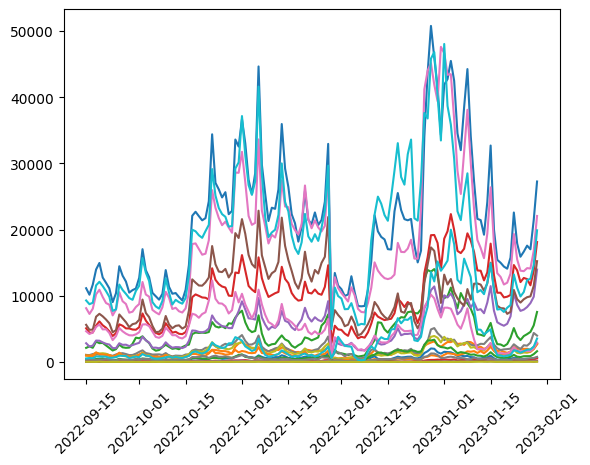

In [195]:
for col in impressions_df.columns:
    plt.plot(impressions_df.loc[:,col])
    plt.xticks(rotation=45)

# Forecasting

# Topic extraction

In [196]:
from bertopic import BERTopic

topic_model = BERTopic(min_topic_size=50, top_n_words=5)
topics, probs = topic_model.fit_transform(kwds_no_bmm)

In [197]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,270,-1_hotel_and_hotels_deposit
1,0,761,0_cheap_christmas_winter_december
2,1,566,1_2023_2024_2022_may
3,2,246,2_from_airport_late_flying
4,3,154,3_inclusive_all_only_holidays
5,4,133,4_february_term_half_feb
6,5,125,5_cheap_2023_september_2022
7,6,124,6_inclusive_all_2023_2024
8,7,121,7_breaks_city_break_short
9,8,114,8_beach_holidays_best_june


In [198]:
topic_model.visualize_topics()

In [201]:
all_topics = topic_model.get_topics()


## Visualise clusters with PCA
Following the [sklearn example](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py)

In [200]:
# from sklearn.decomposition import PCA

# reduced_data = PCA(n_components=2).fit_transform(kwds_embeddings)
# kmeans_model_reduced = KMeans(n_clusters=n_clusters,
#                               max_iter=500,
#                               n_init=100,
#                               init='k-means++',
#                               random_state=SEED)
# kmeans_model_reduced.fit(reduced_data)

# h = 0.02
# x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
# y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Z = kmeans_model_reduced.predict(np.c_[xx.ravel(),
#                                        yy.ravel()].astype(np.float32))
# Z = Z.reshape(xx.shape)
# centroids = kmeans_model_reduced.cluster_centers_
# plt.imshow(Z,
#            interpolation='nearest',
#            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
#            cmap=plt.cm.Pastel2)
# plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# plt.scatter(centroids[:, 0],
#             centroids[:, 1],
#             marker='x',
#             s=169,
#             linewidths=3,
#             color='w',
#             zorder=10)
